# Natural Language Processing

## Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

## 1. Define some very simple data for understanding

In [2]:
corpus = ["apple banana ice", "banana orange fruit", "orange ice fruit", "orange grapes fruit", "banana ice fruit", "grapes fruit ice", 
          "dog cat animal", "cat monkey animal", "monkey dog animal", "conda dog animal", "monkey dog conda", "monkey conda animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'ice'],
 ['banana', 'orange', 'fruit'],
 ['orange', 'ice', 'fruit'],
 ['orange', 'grapes', 'fruit'],
 ['banana', 'ice', 'fruit'],
 ['grapes', 'fruit', 'ice'],
 ['dog', 'cat', 'animal'],
 ['cat', 'monkey', 'animal'],
 ['monkey', 'dog', 'animal'],
 ['conda', 'dog', 'animal'],
 ['monkey', 'dog', 'conda'],
 ['monkey', 'conda', 'animal']]

In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['dog',
 'apple',
 'ice',
 'monkey',
 'fruit',
 'cat',
 'banana',
 'grapes',
 'orange',
 'animal',
 'conda']

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'dog': 0, 'apple': 1, 'ice': 2, 'monkey': 3, 'fruit': 4, 'cat': 5, 'banana': 6, 'grapes': 7, 'orange': 8, 'animal': 9, 'conda': 10}


In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

11


In [7]:
#append UNK
vocab.append('<UNK>')

In [8]:
vocab

['dog',
 'apple',
 'ice',
 'monkey',
 'fruit',
 'cat',
 'banana',
 'grapes',
 'orange',
 'animal',
 'conda',
 '<UNK>']

In [9]:
word2index['<UNK>'] = 0

## 2. Prepare train data

In [10]:
for c in corpus:
    print(c)

['apple', 'banana', 'ice']
['banana', 'orange', 'fruit']
['orange', 'ice', 'fruit']
['orange', 'grapes', 'fruit']
['banana', 'ice', 'fruit']
['grapes', 'fruit', 'ice']
['dog', 'cat', 'animal']
['cat', 'monkey', 'animal']
['monkey', 'dog', 'animal']
['conda', 'dog', 'animal']
['monkey', 'dog', 'conda']
['monkey', 'conda', 'animal']


In [11]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    # here we NOT gonna make input; we shall learn the embedding ourself
    # we cannot train using taking integer as input...
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [12]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[8]
 [2]]
Target:  [[6]
 [4]]


In [13]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [14]:
Z = 0.001

In [15]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [16]:
word_count[',']

0

In [17]:
num_total_words

36

In [18]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [19]:
Counter(unigram_table)

Counter({'dog': 192,
         'apple': 68,
         'ice': 192,
         'monkey': 192,
         'fruit': 227,
         'cat': 114,
         'banana': 155,
         'grapes': 114,
         'orange': 155,
         'animal': 227,
         'conda': 155})

### Negative Sampling

In [20]:
import random
from torch.autograd import Variable

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(torch.LongTensor(idxs))

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

### Testing the negative sampling

In [21]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [22]:
target_batch.shape

torch.Size([2, 1])

In [23]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

#{'grapes': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'ice': 4, 'orange': 5, 'dog': 6, 'monkey': 7, 'conda': 8, 'fruit': 9, 'banana': 10}

tensor([[0, 3, 4],
        [8, 9, 6]])

In [24]:
target_batch[1]

tensor([4])

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [25]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1).view(neg_embeds.size(0), -1) # BxK -> Bx1
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1] = [batch_size, k] ==sum==> [batch_size, 1]
        
        loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)
        
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

## 5. Training

In [26]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 0.895708 | time: 0m 0s
Epoch: 2000 | cost: 0.879396 | time: 0m 0s
Epoch: 3000 | cost: 0.758716 | time: 0m 0s
Epoch: 4000 | cost: 0.676226 | time: 0m 0s
Epoch: 5000 | cost: 0.763175 | time: 0m 0s


## 6. Plotting the embeddings

In [29]:
#list of vocabs
vocab[:10]

['dog',
 'apple',
 'ice',
 'monkey',
 'fruit',
 'cat',
 'banana',
 'grapes',
 'orange',
 'animal']

In [30]:
word = vocab[0]

In [31]:
#numericalization
id = word2index[word]
id

0

In [32]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [33]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-1.0968, -0.4291]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.7533, -0.3877]], grad_fn=<EmbeddingBackward0>))

In [34]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.4084, grad_fn=<SelectBackward0>)

In [35]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

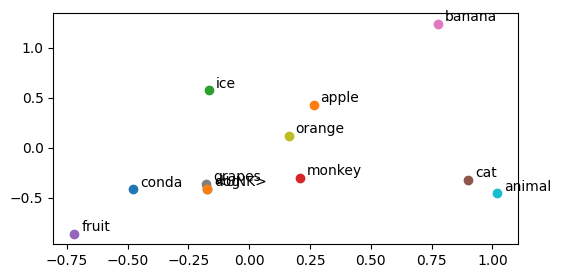

In [36]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [37]:
vocab

['dog',
 'apple',
 'ice',
 'monkey',
 'fruit',
 'cat',
 'banana',
 'grapes',
 'orange',
 'animal',
 'conda',
 '<UNK>']

In [38]:
#let's try similarity between first and second, and second and third
monkey       = get_embed('monkey')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [39]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"monkey vs. fruit: ",     cos_sim(monkey, fruit))
print(f"monkey vs. animal: ",    cos_sim(monkey, animal))
print(f"monkey vs. monkey: ",    cos_sim(monkey, monkey))

monkey vs. fruit:  0.27110743333757853
monkey vs. animal:  0.8533321204537642
monkey vs. monkey:  1.0


In [40]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"monkey vs. fruit: ",     cos_sim(monkey, fruit))
print(f"monkey vs. animal: ",    cos_sim(monkey, animal))
print(f"monkey vs. monkey: ",    cos_sim(monkey, monkey))

monkey vs. fruit:  0.2711074333375785
monkey vs. animal:  0.853332120453764
monkey vs. monkey:  1
